In [68]:
import pandas as pd
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np

In [69]:
# centr = 10
# diff = 6
# edge = 4
# label = 3
# all = 60

# dataset = 'social_media'

In [70]:
# centr = 6
# diff = 4
# edge = 2
# label = 5
# all = 60

# dataset = 'sst5'

In [71]:
# centr = 10
# diff = 6
# edge = 4
# label = 4
# all = 80

# dataset = 'ag_news'

In [72]:
centr = 2
diff = 1
edge = 1
label = 20
all = 80

dataset = '20_newsgroups'

In [73]:
centr = 2
diff = 1
edge = 1
label = 24
all = 96

dataset = 'go_emotions'

In [74]:
df = pd.read_csv(f'../Adata/{dataset}/train_subset.csv')
df = df.dropna()


In [75]:
df

,text,label
0,Ok.... he can *call* it the State of the Union...,disapproval
1,Wheres the telescope?,curiosity
2,> Why create more jobs when no one is availabl...,confusion
3,[NAME] deserves to play for a proper club ffs.,admiration
4,"I'm sorry, do people NOT listen to [NAME] 9th ...",gratitude
...,...,...
1915,"Yeah, i dont know bout you guys, but my parent...",approval
1916,This is hilarious! Sounds similar to my buddy'...,amusement
1917,But that jumper looks hella cosy,joy
1918,Sorry. This thing knows whats up!,remorse


Selected Points:
                                                 text        label  cluster
25  Tool fan from the U.S. here. Something seems o...          joy       10
31  I'm happy however those two don't get a ring. ...          joy       13
14  I've recently figured out I'm the perfect mix ...         love       15
0   Ok.... he can *call* it the State of the Union...  disapproval       18
39  I get excited reading headlines like this........   excitement       17


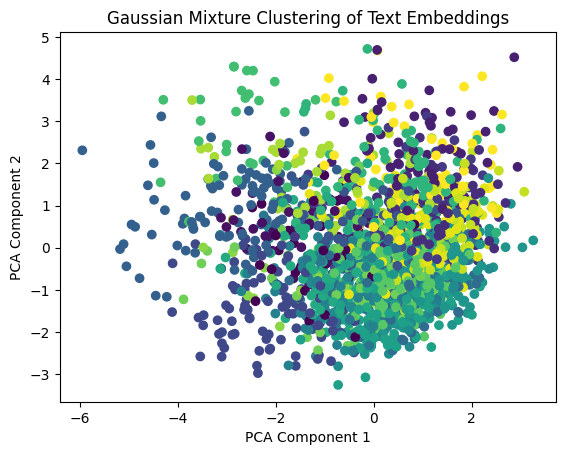

In [76]:
import numpy as np
import pandas as pd
import torch
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

# Inicjalizacja modelu BERT i tokenizera
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        if isinstance(text, str):  # Upewnij się, że tekst jest typu string
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
            # Pobieranie embeddingu (średnia warstwa ukryta)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
        else:
            print(f"Warning: Skipping non-string input: {text}")
    return np.array(embeddings)

# Załóżmy, że masz DataFrame z tekstami
# df = pd.read_csv('your_data.csv')  # Zakładam, że masz DataFrame z kolumną 'text'

# Pobierz embeddingi z tekstów w df
embeddings = get_bert_embeddings(df['text'].tolist())

# Zastosowanie PCA w celu obniżenia wymiarowości dla wizualizacji
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Użycie Gaussian Mixture Model do klasteryzacji
n_clusters = label
gmm = GaussianMixture(n_components=n_clusters)
gmm_labels = gmm.fit_predict(embeddings)

# Dodanie wyników klasteryzacji do DataFrame
df['cluster'] = gmm_labels

# Obliczanie centroidów dla każdej klasy
def calculate_centroids(embeddings, labels, n_classes):
    centroids = []
    for i in range(n_classes):
        centroid = np.mean(embeddings[labels == i], axis=0)
        centroids.append(centroid)
    return np.array(centroids)

centroids = calculate_centroids(embeddings, gmm_labels, n_clusters)

# Funkcja do klasyfikacji punktów na podstawie odległości od centroidów
def classify_points(embeddings, labels, centroids):
    central_points = []
    boundary_points = []
    
    # Oblicz odległości od centroidów
    distances_to_centroids = pairwise_distances(embeddings, centroids)
    
    for i, point in enumerate(embeddings):
        label = labels[i]
        distance_to_own_class_centroid = distances_to_centroids[i, label]
        
        # Centralne punkty - najbliższe centroidowi
        central_points.append((i, distance_to_own_class_centroid))
        
    # Posortowanie punktów od najbliższego do najdalszego względem centroidu
    central_points = sorted(central_points, key=lambda x: x[1])  # Posortowane po odległości
    central_points = [x[0] for x in central_points]  # Weź indeksy
    
    # Wybieranie 10 centralnych punktów (najbliższe centroidowi)
    central_sample = central_points[:10]
    
    # Wybieranie 4 brzegowych punktów (najdalsze od centroidu)
    boundary_points = sorted(central_points, key=lambda x: distances_to_centroids[x, label], reverse=True)[:4]
    
    return central_sample, boundary_points

# Funkcja do wyboru punktów sąsiadujących
def select_neighboring_points(embeddings, labels, centroids, n_neighbors):
    neighboring_points = []
    
    # Oblicz odległości między wszystkimi punktami
    distances = pairwise_distances(embeddings)
    
    for i, point in enumerate(embeddings):
        # Odległości od punktu i do wszystkich innych punktów
        distances_to_others = distances[i]
        
        # Liczymy liczbę sąsiadów z innych klas (punkty, które są w pobliżu)
        neighbors_count = 0
        for j in range(len(embeddings)):
            if labels[i] != labels[j] and distances_to_others[j] < np.percentile(distances[i], 25):  # blisko
                neighbors_count += 1
        
        # Jeśli punkt ma wielu sąsiadów z innych klas, dodaj go do listy
        neighboring_points.append((i, neighbors_count))
    
    # Sortowanie punktów po liczbie sąsiadów z innych klas
    neighboring_points = sorted(neighboring_points, key=lambda x: x[1], reverse=True)
    
    # Wybieranie 6 punktów z największą liczbą sąsiadów
    neighboring_sample = [x[0] for x in neighboring_points[:n_neighbors]]
    
    return neighboring_sample


# Zbiór punktów do wyboru (20 punktów na każdą klasę)
selected_points = []

# Dla każdej klasy, wybieramy 10 centralnych, 4 brzegowe i 6 sąsiadujących
for i in range(n_clusters):
    # Wybierz indeksy punktów w danej klasie
    class_indices = np.where(gmm_labels == i)[0]
    
    # Podziel punkty na centralne, brzegowe
    central_points, boundary_points = classify_points(
        embeddings[class_indices], gmm_labels[class_indices], centroids
    )
    
    # Wybieranie 10 centralnych, 4 brzegowych
    central_sample = central_points[:centr]  # Zamiast losowo, bierzemy te najbliższe
    boundary_sample = boundary_points[:edge]  # Zamiast losowo, bierzemy te najdalsze
    
    # Wybieranie punktów sąsiadujących (na podstawie liczby sąsiadów z innych klas)
    neighboring_sample = select_neighboring_points(embeddings[class_indices], gmm_labels[class_indices], centroids, n_neighbors=diff)
    
    # Dodaj wybrane punkty do listy
    selected_points.extend(central_sample)
    selected_points.extend(boundary_sample)
    selected_points.extend(neighboring_sample)

# Tworzenie DataFrame z wybranymi punktami
selected_df = df.iloc[selected_points]

# Wyświetlenie wyników
print(f"Selected Points:\n{selected_df.head()}")

# Możesz również wizualizować dane w 2D, jeśli chcesz zobaczyć, jak klastery są rozmieszczone
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=gmm_labels, cmap='viridis')
plt.title('Gaussian Mixture Clustering of Text Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [77]:
len(selected_df)

96

In [78]:
len(selected_df['label'].unique())

21

In [79]:
selected_df.to_csv(f'selected_samples/{dataset}/gaussian.csv', index=False)